In [39]:
import pandas as pd
import xgboost as xgb
import numpy as np

In [45]:
spammer_order = "spammer_order.csv"
feat_list = ['post_num', 'follower_num', 'followee_num', 'content_similar',
 'figure_jing', 'figure_url', 'figure_face', 'figure_RRT', 'figure_face_every',
 'figure_jing_every', 'figure_url_every', 'figure_url_single', 'figure_jing_single',
 'figure_at', 'figure_at_every', 'figure_at_single', 'average_repost', 'average_comm',
 'late_night_times', 'is_regular', 'shorttime_times', 'active_day_ratio', 'day_interval_variance',
 'day_in_variance', 'follow_ratio']

raw_file = pd.read_csv(spammer_order)
data = raw_file[feat_list]
target = raw_file[['is_spammer']]

In [41]:
# split to train and test sets
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    data, target, test_size=0.33, random_state=0)

In [42]:
train_X = train_X.as_matrix()
test_X = test_X.as_matrix()
train_y = train_y.as_matrix()

In [43]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
gbm.fit(train_X, train_y)
predictions = gbm.predict(test_X)

In [44]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.65%


In [56]:
# or use 10 fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, data, target, cv=kfold)
print results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# initial mean accuracy 48.54%, deviation 31.44%

ValueError: Found input variables with inconsistent numbers of samples: [1716, 9]

## start adjusting the xgboost model parameters

In [116]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
    

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [76]:
data = pd.read_csv('spammer_order.csv')

In [77]:
data.shape

(1716, 33)

In [78]:
feat_list = ['post_num', 'follower_num', 'followee_num', 'content_similar',
 'figure_jing', 'figure_url', 'figure_face', 'figure_RRT', 'figure_face_every',
 'figure_jing_every', 'figure_url_every', 'figure_url_single', 'figure_jing_single',
 'figure_at', 'figure_at_every', 'figure_at_single', 'average_repost', 'average_comm',
 'late_night_times', 'is_regular', 'shorttime_times', 'active_day_ratio', 'day_interval_variance',
 'day_in_variance', 'follow_ratio']
target='is_spammer'

In [89]:
data[target] = data[target].map(dict(yes=1, no=0))
data[target].value_counts()

1    858
0    858
Name: is_spammer, dtype: int64

In [101]:
def modelfit(alg, dtrain, cv_folds=5, early_stopping_rounds=50):
    
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[feat_list].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[feat_list], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[feat_list])
    dtrain_predprob = alg.predict_proba(dtrain[feat_list])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [118]:
def cross_val(alg, data):
    kfold = KFold(n_splits=10, random_state=7)
    train = data[feat_list]
    res = data[target]
    results = cross_val_score(alg, train, res, cv=kfold)
    print results
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    # initial mean accuracy 48.54%, deviation 31.44%

## 1. Find the number of estimators for a high learning rate


Model Report
Accuracy : 0.9988
AUC Score (Train): 1.000000
[ 0.62209302  0.56976744  0.14534884  0.77906977  0.99418605  0.02906977
  0.65497076  0.60233918  0.57309942  0.01754386]
Accuracy: 49.87% (31.02%)


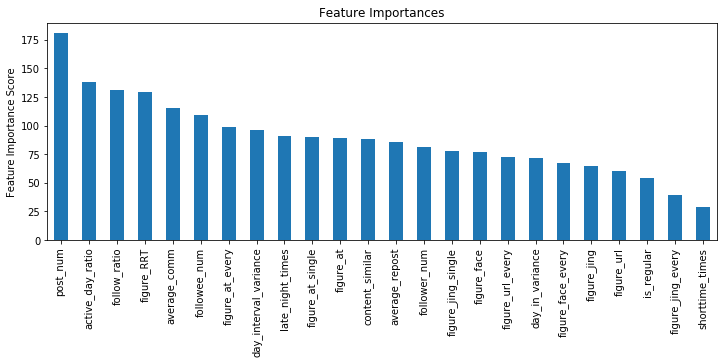

In [119]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, data)

cross_val(xgb1, data)

In [94]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [95]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.73853, std: 0.14588, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.74938, std: 0.13139, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.76485, std: 0.11236, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.73046, std: 0.13594, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.74469, std: 0.12336, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.75956, std: 0.10769, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.74040, std: 0.13499, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.75877, std: 0.12029, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.77117, std: 0.10915, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.73537, std: 0.13339, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.75511, std: 0.11888, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.76153, std: 0.10457, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5

In [97]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[6,7,8],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [98]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.76303, std: 0.11195, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.77081, std: 0.09711, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.77529, std: 0.09582, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.75858, std: 0.10624, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.77117, std: 0.10915, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.78041, std: 0.09736, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: 0.75987, std: 0.10989, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.76625, std: 0.10350, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.76502, std: 0.10417, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 7, 'min_child_weight': 6},
 0.7804123012412337)

In [105]:
param_test2b = {
    'min_child_weight':[6,8,10,12, 14, 16]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=7,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=2, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12, 14, 16]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [106]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.78041, std: 0.09736, params: {'min_child_weight': 6},
  mean: 0.78582, std: 0.09375, params: {'min_child_weight': 8},
  mean: 0.79661, std: 0.07896, params: {'min_child_weight': 10},
  mean: 0.80972, std: 0.06539, params: {'min_child_weight': 12},
  mean: 0.82104, std: 0.04935, params: {'min_child_weight': 14},
  mean: 0.83822, std: 0.04270, params: {'min_child_weight': 16}],
 {'min_child_weight': 16},
 0.8382241428808677)

In [111]:
param_test2c = {
    'min_child_weight':[16, 20, 24, 28, 32, 36, 40]
}
gsearch2c = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=7,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2c, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2c.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=2, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [16, 20, 24, 28, 32, 36, 40]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [112]:
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

([mean: 0.83822, std: 0.04270, params: {'min_child_weight': 16},
  mean: 0.85044, std: 0.03144, params: {'min_child_weight': 20},
  mean: 0.86194, std: 0.03041, params: {'min_child_weight': 24},
  mean: 0.86878, std: 0.03064, params: {'min_child_weight': 28},
  mean: 0.87156, std: 0.02665, params: {'min_child_weight': 32},
  mean: 0.87476, std: 0.02708, params: {'min_child_weight': 36},
  mean: 0.87476, std: 0.02559, params: {'min_child_weight': 40}],
 {'min_child_weight': 36},
 0.8747646590430703)

In [113]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [114]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.76872, std: 0.10037, params: {'gamma': 0.0},
  mean: 0.77219, std: 0.10086, params: {'gamma': 0.1},
  mean: 0.76760, std: 0.10067, params: {'gamma': 0.2},
  mean: 0.76590, std: 0.10160, params: {'gamma': 0.3},
  mean: 0.76757, std: 0.10231, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.7721892820668668)

In [120]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=7,
        min_child_weight=36,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
# modelfit(xgb2, data)
cross_val(xgb2, data)

[ 0.68604651  0.63953488  0.29069767  0.85465116  0.94767442  0.73837209
  0.76608187  0.33918129  0.3625731   0.06432749]
Accuracy: 56.89% (27.18%)


### Tune subsample and colsample_bytree

In [121]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
                                        min_child_weight=36, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=36, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [122]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.86950, std: 0.02939, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.86900, std: 0.03143, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.86873, std: 0.03514, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.86805, std: 0.03126, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.86560, std: 0.03055, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.86970, std: 0.02942, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.87064, std: 0.03040, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.86570, std: 0.03226, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.87144, std: 0.02966, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.87274, std: 0.02856, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.86649, std: 0.02999, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.86459, std: 0.03378, params: {'subsample': 0.9, 'colsample_bytree'

### regularization

In [124]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
                                        min_child_weight=36, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=36, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [125]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.86649, std: 0.02999, params: {'reg_alpha': 1e-05},
  mean: 0.86819, std: 0.03117, params: {'reg_alpha': 0.01},
  mean: 0.86591, std: 0.02962, params: {'reg_alpha': 0.1},
  mean: 0.86758, std: 0.02934, params: {'reg_alpha': 1},
  mean: 0.85370, std: 0.02755, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.8681899913493742)

In [128]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
                                        min_child_weight=36, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(data[feat_list],data[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=36, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [129]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.86649, std: 0.02999, params: {'reg_alpha': 0},
  mean: 0.86650, std: 0.02999, params: {'reg_alpha': 0.001},
  mean: 0.86790, std: 0.03099, params: {'reg_alpha': 0.005},
  mean: 0.86819, std: 0.03117, params: {'reg_alpha': 0.01},
  mean: 0.86789, std: 0.03002, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.01},
 0.8681899913493742)


Model Report
Accuracy : 0.8741
AUC Score (Train): 0.950296


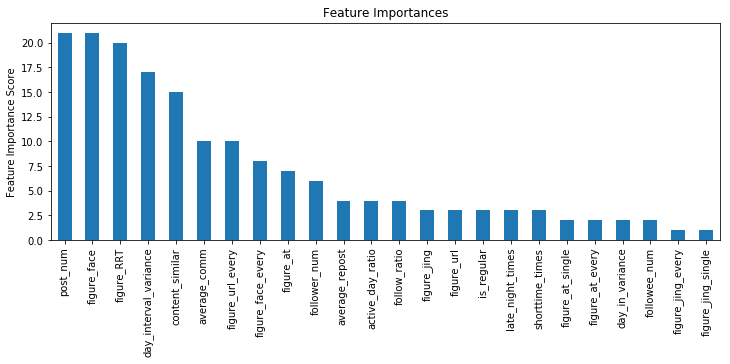

In [131]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=7,
        min_child_weight=36,
        gamma=0.1,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, data)

In [132]:
cross_val(xgb3, data)

[ 0.6627907   0.68023256  0.27906977  0.87209302  0.97674419  0.75581395
  0.85964912  0.87719298  0.71929825  0.01754386]
Accuracy: 67.00% (28.33%)
